# Réalisez une veille technique : 
*Notebook Mission 2 - Réalisez une veille technique*

**Classification superviée d’images via les Visions Transformers (ViT)**

Il s'agit de réaliser un POC qui met en oeuvre cette nouvelle technique avec les données image déjà exploitées dans le cadre du projet 6.

In [3]:
# fonctions personnelles pour le pré traitement des données textuelles
import pre_treatment_text as ptt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import OneCycleLR

import transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor
from transformers import TrainingArguments, Trainer

from tqdm import tqdm

from datasets import Dataset 
import evaluate

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("torch version", torch.__version__)
#print("scipy version", scipy.__version__)
#print("statsmodels version", statsmodels.__version__)

print("sklearn version", sklearn.__version__)
print("transformers version", transformers.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
torch version 2.6.0+cpu
sklearn version 1.6.1
transformers version 4.48.1


## 1 - Préparation des données

In [3]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
# Transformer l'arbre des catégories en 7 catégories principales
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
data['category'] = y

In [7]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing


**Créons les dossiers train, val, test qui contiennent les images**

In [25]:
# Définir les dossiers contenant les images
source_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/Images/"  # Dossier où se trouvent les images
train_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"  
val_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_val"
test_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test" 

# Séparer les données (80% train + validation, 30% test)
df_train_val, df_test = train_test_split(data, test_size=0.20, stratify=data['category'], random_state=42)

# Séparer les données (80% train + 20% validation)
df_train, df_val = train_test_split(df_train_val, test_size=0.20, stratify=df_train_val['category'], random_state=42)

def copy_images(df_subset, destination_folder):
    """ Fonction pour copier les images dans le dossier approprié. """
    for _, row in df_subset.iterrows():
        image_name = row['image']
        category = row['category']

        # Chemin source et destination
        src_path = os.path.join(source_folder, image_name)
        dest_folder = os.path.join(destination_folder, category)
        dest_path = os.path.join(dest_folder, image_name)

        # Créer le dossier s'il n'existe pas
        os.makedirs(dest_folder, exist_ok=True)

        # Vérifier si l'image existe avant de la copier
        if os.path.exists(src_path):
            shutil.copy2(src_path, dest_path)  # Copie sans supprimer l'original
            print(f"✅ {image_name} copié dans {dest_folder}")
        else:
            print(f"⚠️ Image non trouvée : {image_name}")

# Copier les images dans les dossiers appropriés
print("📂 Copie des images d'entraînement...")
copy_images(df_train, train_folder)

print("📂 Copie des images de validation...")
copy_images(df_val, val_folder)

print("📂 Copie des images de test...")
copy_images(df_test, test_folder)

print("✅ Opération terminée !")

📂 Copie des images d'entraînement...
✅ 762b6b22cccf91935e92446efe298fe3.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Baby Care
✅ fc93a41f31c4e997fbfcc5bd0a63ee65.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Watches
✅ 503bb08f7bdf6a395ec564dd1dc83619.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Kitchen  Dining
✅ e4922f01eda047582cd72e9d1063ab7a.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Decor  Festive Needs
✅ cc2acb156df3202f172b280132ab459a.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Furnishing
✅ d98147c96d2eebf723b2b67d791bcdaa.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Watches
✅ b91b13aceec0a140944a2c8915e45e59.jpg copié dans C:/Users/admin/Documents/Projet

**Créons les datasets "images" train, validation, et test**

- Augmentation des données avec plusieurs techniques (recadrage aléatoire, retournement horizontal, rotation, variation couleurs...
- Création des jeux de données dans 3 datasets : train, validation, test

In [9]:
# Define dataset paths
data_dir = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart"

# Define transformations for data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and data loaders
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "images_per_category"), transform=train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "images_per_category_val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "images_per_category_test"), transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 2 - Vision transformers

Tout comme les modèles basés sur les transformateurs ont révolutionné le NLP, nous assistons maintenant à une explosion d’articles les appliquant à toutes sortes d’autres domaines. L’un des plus révolutionnaires d’entre eux était le Vision Transformer (ViT), qui a été introduit en juin 2021 par une équipe de chercheurs de Google Brain.
Cet article a exploré comment vous pouvez tokeniser des images, tout comme vous le feriez pour des phrases, afin qu’elles puissent être transmises à des modèles de transformateur pour l’entraînement. C’est un concept assez simple, vraiment...

- Fractionner une image en une grille de patchs de sous-images
- Intégrez chaque patch avec une projection linéaire
- Chaque patch incorporé devient un jeton, et la séquence résultante de correctifs incorporés est la séquence que vous transmettez au modèle.

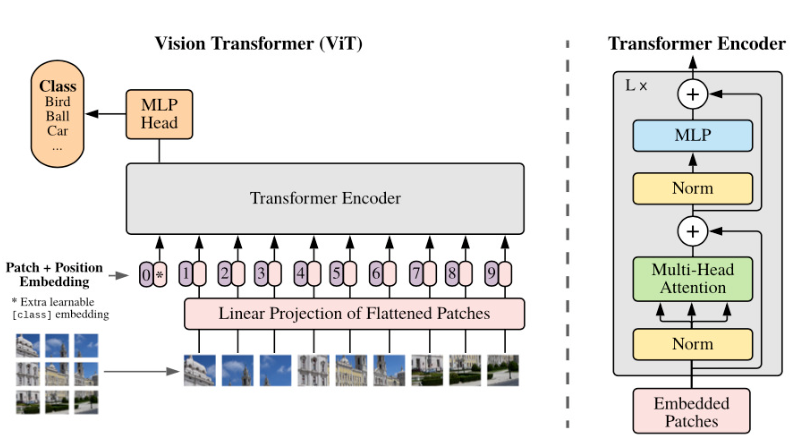



## 3 - Classifier les images

**Méthode inspirée du Kernel https://www.kaggle.com/code/adhoppin/testing-vit-for-image-classification/notebook :**

- Initaliser un extracteur de features
- Charger le modèle ViT pré-entraîné en indiquant les 7 catégories
- Définir la fonction de perte
- Définir l'optimiseur sur AdamW avec un taux d'apprentissage de 0.0001
- Création d'un scheduler pour ajuster le taux d'apprentissage pendant l'entraînement (max  = 0.001)

In [11]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adjust learning rate

# Learning rate scheduler with warm-up
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Fin pré entraînement")

C:\Users\admin\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fin pré entraînement


- Initialiser les listes pour sauvegarder les métriques de chaque epochs

In [19]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_validation_accuracy = 0.0

- Entraîner le modèle sur 20 epochs
- Calculer l'accuracy et la fonction de perte, et sauvegarder le meilleur modèle à la fin de chaque epochs

In [21]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(valid_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_validation_accuracy:
        best_validation_accuracy = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step()

C:\Users\admin\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/20] Train Loss: 1.6158 | Train Acc: 70.24% Val Loss: 1.4215 | Val Acc: 79.76%
Epoch [2/20] Train Loss: 1.3720 | Train Acc: 76.64% Val Loss: 1.1684 | Val Acc: 81.55%
Epoch [3/20] Train Loss: 1.1295 | Train Acc: 80.36% Val Loss: 0.9631 | Val Acc: 80.36%
Epoch [4/20] Train Loss: 0.9357 | Train Acc: 83.18% Val Loss: 0.8181 | Val Acc: 82.74%
Epoch [5/20] Train Loss: 0.8096 | Train Acc: 82.59% Val Loss: 0.7038 | Val Acc: 83.93%
Epoch [6/20] Train Loss: 0.6529 | Train Acc: 86.90% Val Loss: 0.6376 | Val Acc: 85.71%
Epoch [7/20] Train Loss: 0.5805 | Train Acc: 88.24% Val Loss: 0.6053 | Val Acc: 83.33%
Epoch [8/20] Train Loss: 0.4984 | Train Acc: 89.88% Val Loss: 0.5620 | Val Acc: 85.71%
Epoch [9/20] Train Loss: 0.4540 | Train Acc: 90.77% Val Loss: 0.5304 | Val Acc: 85.71%
Epoch [10/20] Train Loss: 0.4067 | Train Acc: 90.92% Val Loss: 0.5223 | Val Acc: 84.52%
Epoch [11/20] Train Loss: 0.3644 | Train Acc: 92.41% Val Loss: 0.5328 | Val Acc: 83.33%
Epoch [12/20] Train Loss: 0.2751 | Train 

- Evaluer le meilleur modèle avec le jeu de test

In [23]:
# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.6200 | Test Accuracy: 80.00%


- Tracer les courbes Accuracy et Loss

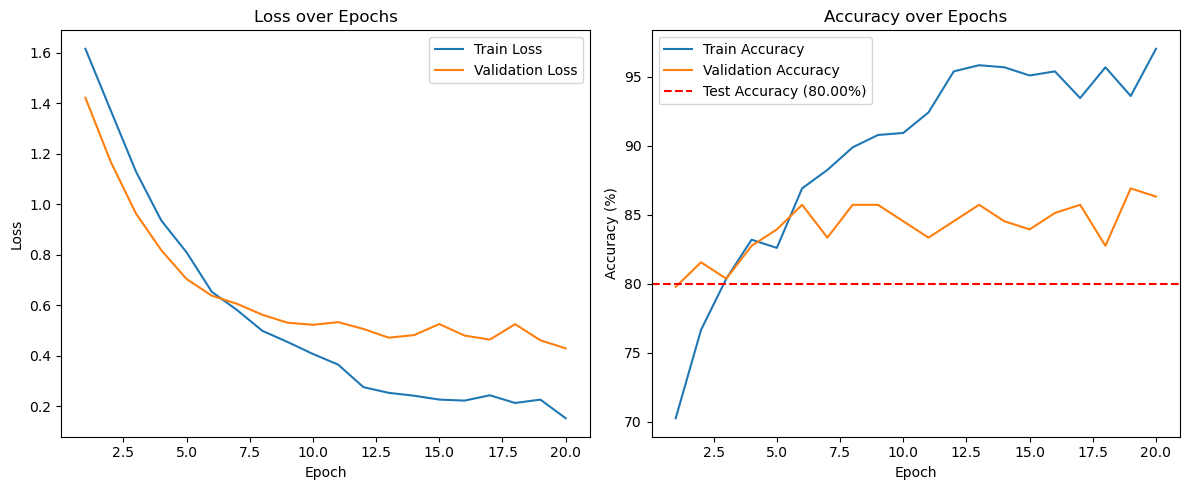

In [25]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.axhline(test_accuracy, color='r', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f}%)')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## 4 - Feature importance

Habituellement j'utilise la librairie SHAP pour la feature importance globale et locale, mais dans un contexte ViT, cette solution n'est pas adaptée. Le formatage pour SHAP du modèle Transformer + image est complexe. Et le rendu est peu interprétable.

Il est donc préférable d'utiliser "Attention Rollout" pour la feature importance. On obtiendra une importance par rapport à l’image, à travers toutes les couches du modèle. C'est à dire :
- "quels pixels ont compté" (local),
- Et "comment l’attention s’est propagée à travers toutes les couches" pour cette image.

En faisant la moyenne sur l'ensemble des images des images du jeu de tests, et la moyenne par catégorie, on peut visisualiser l'importance des zones des images.

**Visualisation sur une image**

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Min: 0.0004148737 Max: 0.010734034 Mean: 0.001908597


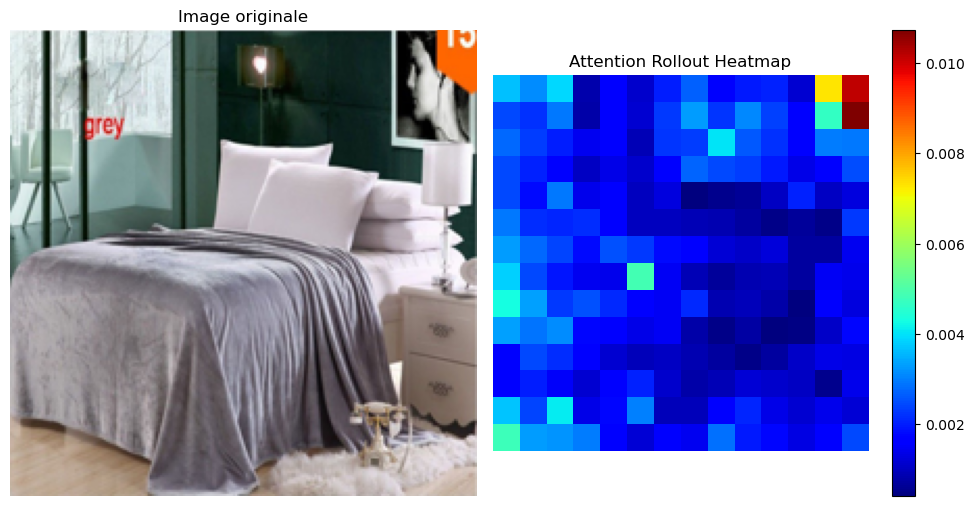

In [46]:
# --- Image path ---
img_path = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test/Home Furnishing/bba68d75eff1b7b5eef7f6c1c68f2227.jpg"

# --- Load model ---
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=7)
model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Image preprocessing ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# --- Forward pass with attention ---
with torch.no_grad():
    outputs = model(input_tensor, output_attentions=True)
    attentions = outputs.attentions

# --- Rollout function ---
def compute_rollout_attention(attn_list, discard_ratio=0.9):
    result = torch.eye(attn_list[0].size(-1)).to(attn_list[0].device)
    
    for attn in attn_list:
        attn_heads_fused = attn.mean(dim=1)  # moyenne sur les têtes

        # Masquage des plus faibles valeurs
        flat = attn_heads_fused.view(attn_heads_fused.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim=-1, largest=False)
        flat.scatter_(-1, indices, 0)

        attn_heads_fused = flat.view_as(attn_heads_fused)

        # 🔥 Normalisation avec epsilon pour éviter NaNs
        attn_heads_fused = attn_heads_fused / (attn_heads_fused.sum(dim=-1, keepdim=True) + 1e-6)
        result = attn_heads_fused @ result

    return result

# --- Compute heatmap ---
attn_rollout = compute_rollout_attention(attentions, discard_ratio=0.9)
mask = attn_rollout[0, 0, 1:]
mask = mask.reshape(14, 14).cpu().numpy()

# --- image originale ---
image_resized = image.resize((224, 224))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Image originale")
plt.axis("off")

# --- Display heatmap only ---
print("Min:", mask.min(), "Max:", mask.max(), "Mean:", mask.mean())
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='jet')
plt.colorbar()
plt.title("Attention Rollout Heatmap")
plt.axis("off")

plt.tight_layout()
plt.show()

**Visualisation des heatmap sur l'ensemble des images du fichier de tests**

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


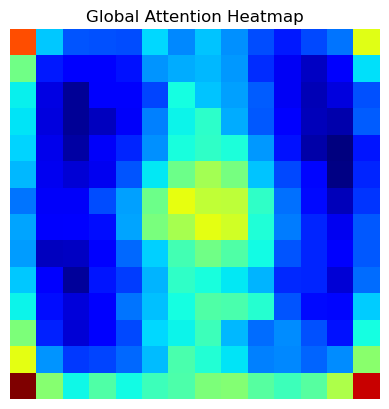

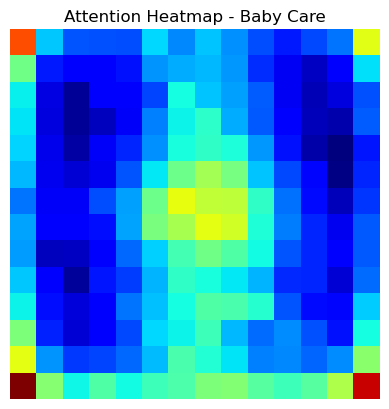

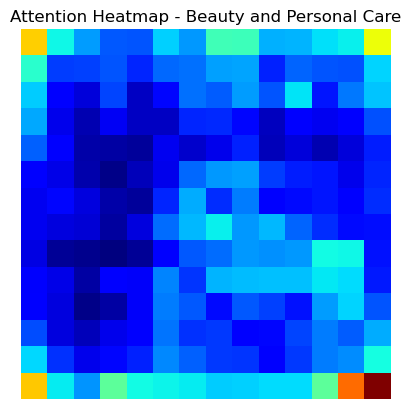

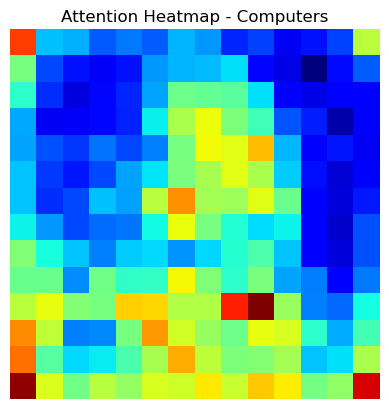

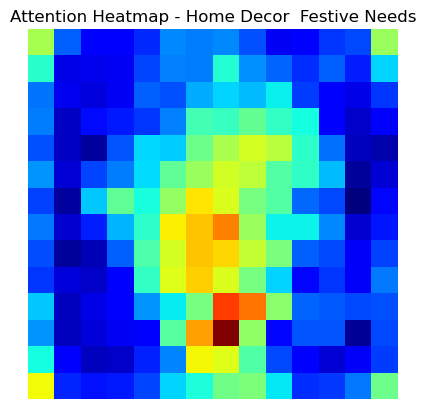

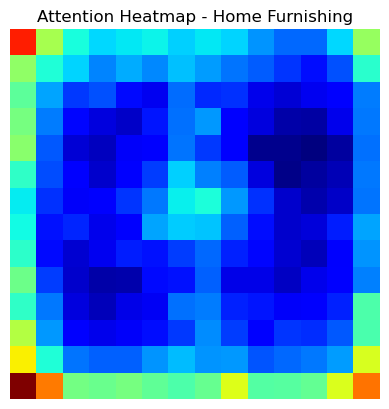

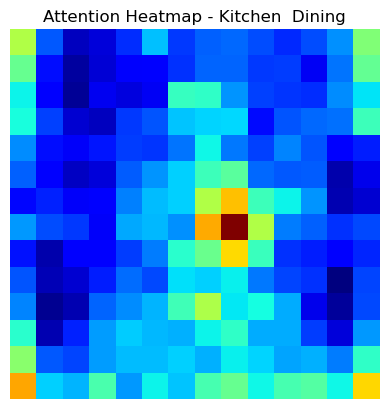

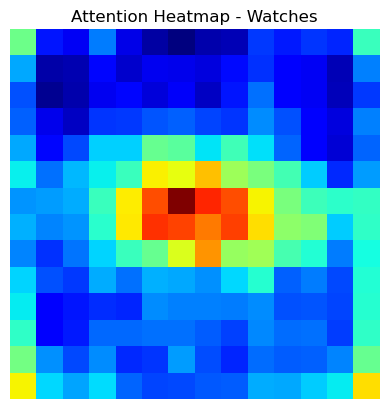

In [48]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Fonction pour charger les images et calculer l'attention rollout
def compute_rollout_attention(attn_list, discard_ratio=0.9):
    num_tokens = attn_list[0].size(-1)
    result = torch.eye(num_tokens).to(attn_list[0].device)

    for attn in attn_list:
        attn_heads_fused = attn.mean(dim=1)
        flat = attn_heads_fused.view(attn_heads_fused.size(0), -1)
        num_discard = int(flat.size(-1) * discard_ratio)
        if num_discard > 0:
            _, indices = flat.topk(num_discard, dim=-1, largest=False)
            flat.scatter_(-1, indices, 0.0)
        attn_heads_fused = flat.view_as(attn_heads_fused)

        attn_sum = attn_heads_fused.sum(dim=-1, keepdim=True)
        attn_sum = attn_sum + 1e-6  # Évite la division par 0
        attn_heads_fused = attn_heads_fused / attn_sum

        result = attn_heads_fused @ result

    return result

# Fonction pour calculer la heatmap moyenne
def compute_average_heatmap(image_paths, model, device, transform, discard_ratio=0.9):
    total_attention = None
    num_images = 0

    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor, output_attentions=True)
            attentions = outputs.attentions  # Liste des attentions [batch, heads, tokens, tokens]

        # Calcul de l'attention rollout
        attn_rollout = compute_rollout_attention(attentions, discard_ratio=discard_ratio)
        mask = attn_rollout[0, 0, 1:]  # Remove CLS token
        mask = mask.reshape(14, 14).cpu().numpy()  # Redimensionner à 14x14 patchs

        if total_attention is None:
            total_attention = mask
        else:
            total_attention += mask

        num_images += 1

    # Moyenne de l'attention pour toutes les images
    average_attention = total_attention / num_images
    return average_attention

# Configuration du modèle et de la transformation
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=7)
model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dossier contenant les images (à adapter selon ton environnement)
base_path = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test"

# Calcul de la heatmap moyenne globale et par catégorie
category_heatmaps = {}
global_attention = None
category_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

for category in category_folders:
    category_path = os.path.join(base_path, category)
    image_paths = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(".jpg") or f.endswith(".png")]
    
    # Calcul de la heatmap moyenne pour cette catégorie
    category_attention = compute_average_heatmap(image_paths, model, device, transform)
    category_heatmaps[category] = category_attention

    # Ajouter au calcul global
    if global_attention is None:
        global_attention = category_attention
    else:
        global_attention += category_attention

# Moyenne globale de toutes les catégories
global_attention /= len(category_folders)

# Visualisation des résultats
def show_attention_heatmap(heatmap, title="Attention Heatmap"):
    plt.imshow(heatmap, cmap='jet')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Heatmap globale
show_attention_heatmap(global_attention, title="Global Attention Heatmap")

# Heatmaps par catégorie
for category, attention in category_heatmaps.items():
    show_attention_heatmap(attention, title=f"Attention Heatmap - {category}")
